In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('..')

In [13]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import utils.nn as tu

from tqdm.auto import trange

T.__version__

'1.3.1'

In [3]:
def imshow(img, size=8):
    import math
    
    if type(img) is not np.ndarray:
        img = img.detach().cpu().numpy()

    num_dims = len(img.shape)

    if num_dims == 4:
        bs = img.shape[0]
        channels = img.shape[1]

        rows = math.ceil(math.sqrt(bs))
        cols = math.ceil(bs / rows)
        new_bs = rows * cols
        H, W = img.shape[2], img.shape[3]

        img = np.pad(img, ((0, new_bs - bs), (0, 0), (0, 0), (0, 0)))
        img = img.reshape(rows, cols, channels, H, W)
        img = np.concatenate(np.split(img, rows, axis=0), axis=3)
        img = np.concatenate(np.split(img, cols, axis=1), axis=4)
        img = img[0, 0]

    img = np.transpose(img, (1, 2, 0))
    if img.shape[-1] == 1:
        img = img[:, :, 0]
    
    fig, ax = plt.subplots(figsize=(size, size))
    ax.imshow(img)
    plt.tight_layout()

In [4]:
# img = np.random.rand(11, 3, 16, 16)
# imshow(img)

torch.Size([16, 3, 32, 32])

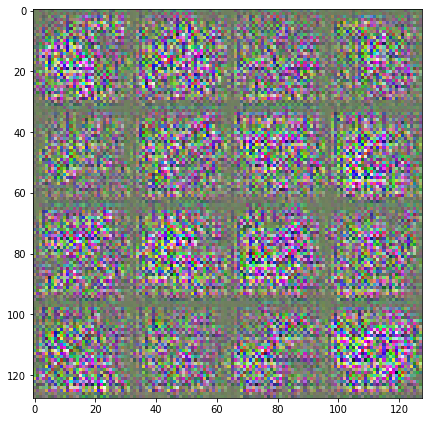

In [151]:
class GlyphEncoder(nn.Module):
    def __init__(self, num_glyphs, img_channels):
        super().__init__()

        self.net = nn.Sequential(
            nn.Embedding(num_glyphs, 32),
            tu.reshape(-1, 32, 1, 1),
            tu.deconv_block(32 , 64          , ks=5, s=2, p=1),
            nn.Dropout(0.2),
            tu.deconv_block(64 , 32          , ks=5, s=1, p=2),
            nn.Dropout(0.5),
            tu.deconv_block(32 , 32          , ks=5, s=1, p=2),
            tu.deconv_block(32 , 16          , ks=5, s=2, p=1),
            nn.Dropout(0.3),
            tu.deconv_block(16 , 8           , ks=5, s=1, p=2),
            nn.Dropout(0.01),
            tu.deconv_block(8  , 4           , ks=5, s=2, p=1),
            tu.deconv_block(4  , img_channels, ks=4, s=2, p=0, a=nn.Sigmoid()),
        )

    def forward(self, z):
        return self.net(z)
    

num_glyphs = 15
bs = 16

glyph_encoder = GlyphEncoder(num_glyphs, img_channels=3)
glyph_ids = T.randint(0, num_glyphs, size=(bs,)).long()
fake_img = glyph_encoder(glyph_ids)

imshow(fake_img, size=6)
fake_img.shape

In [185]:
class GlyphDecoder(nn.Module):
    def __init__(self, in_channels, num_glyphs):
        super().__init__()
        
        self.net = nn.Sequential(
            tu.conv_to_flat(
                [in_channels, 16, 32, 64, 128, 128],
                num_glyphs,
                ks=3,
                s=2,
            ),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, x):
        return self.net(x)
    
bs = 16
in_channels = 3
num_glyphs = 15

glyph_decoder = GlyphDecoder(in_channels, num_glyphs)
random_glyphs = T.rand(bs, in_channels, 32, 32)
decoded_glyphs = glyph_decoder(random_glyphs)
T.argmax(decoded_glyphs, dim=1)

tensor([ 9, 11,  3, 10,  5,  5,  5,  3, 10,  3,  3,  0, 10,  2, 13,  3])

In [186]:
class GlyphAE(tu.BaseModule):
    def __init__(self, num_glyphs, img_channels):
        super().__init__()
        bs = 3
        self.num_glyphs = num_glyphs
        self.encoder = GlyphEncoder(num_glyphs, img_channels)
        self.decoder = GlyphDecoder(img_channels, num_glyphs)

        # This is done so that te decoder parameters are initialized
        imgs = self.encoder(self.sample(bs=1))
        self.decoder(imgs)

    @property
    def device(self):
        return next(self.encoder.parameters()).device

    def sample(self, bs):
        return T.randint(0, self.num_glyphs, size=(bs,)).long().to(self.device)

    def forward(self, bs):
        glyph_ids = self.sample(bs)
        generated_glyphs = self.encoder(glyph_ids)
        return generated_glyphs

    def configure_optim(self, lr, bs, noise_size):
        self.noise_size = noise_size
        self.bs = bs
        self.optim = T.optim.Adam(self.parameters(), lr)

    def optim_step(self, *_):
        def apply_noise(t):
            noise = T.normal(0, 1, t.shape)
            noise = noise.to(self.device)
            return t * noise

        glyph_ids = self.sample(self.bs)
        img = self.encoder(glyph_ids)
        img = apply_noise(img)
        glyph_logits = self.decoder(img)
        
        loss = F.nll_loss(glyph_logits, glyph_ids)

        if loss.requires_grad:
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()

        return loss.item(), {
            'glyph_logits': glyph_logits,
            'glyph_ids': glyph_ids,
            'img': img
        }

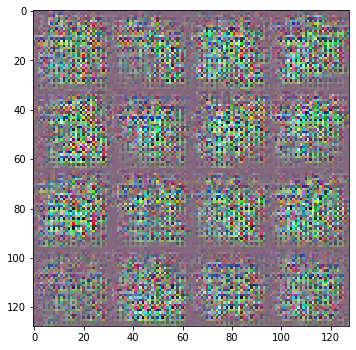

In [187]:
bs = 16
num_glyphs = 15
glyph_ae = GlyphAE(num_glyphs, img_channels=3)

for _ in range(5):
    glyph_ae.configure_optim(lr=0.001, bs=128, noise_size=0.5)
    loss, info = glyph_ae.optim_step()

fake_glyphs = glyph_ae(16)
imshow(fake_glyphs, size=5)

In [189]:
print(glyph_ae.summary())

 > Custom Module                          | 0,393,388
 >               encoder: GlyphEncoder    |   145,949
 >               decoder: GlyphDecoder    |   247,439



In [190]:
num_glyphs = 50
glyph_ae = GlyphAE(num_glyphs, img_channels=1)
glyph_ae = glyph_ae.to('cuda')

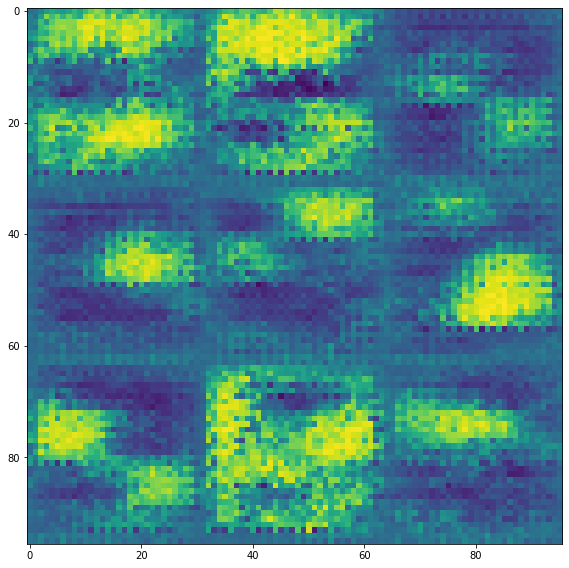

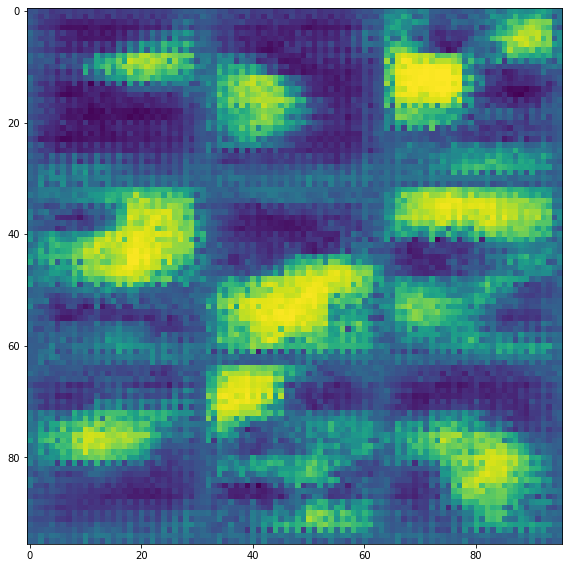

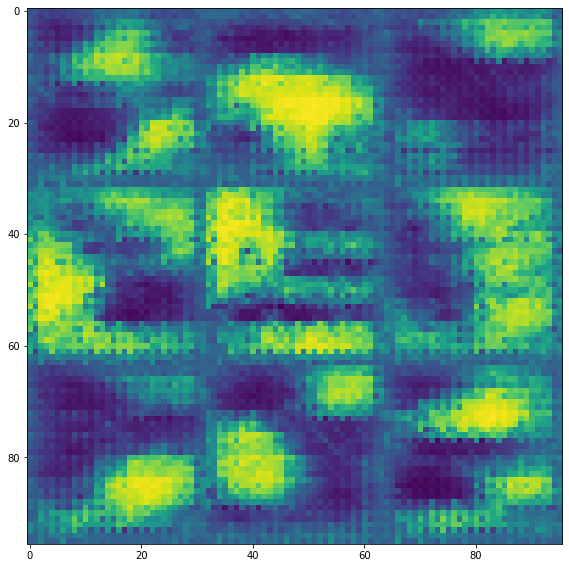

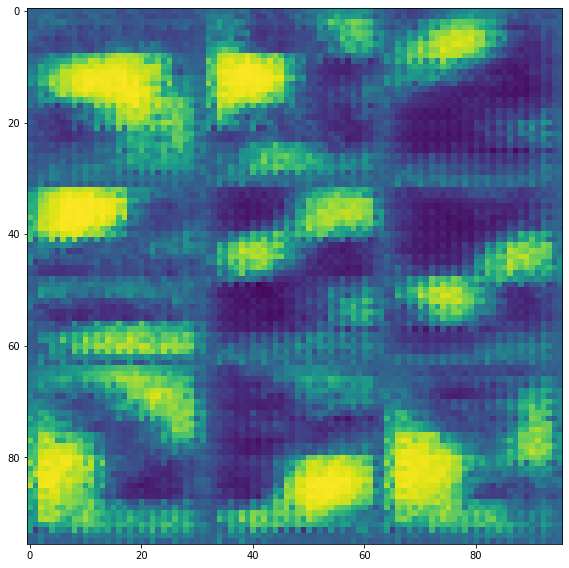

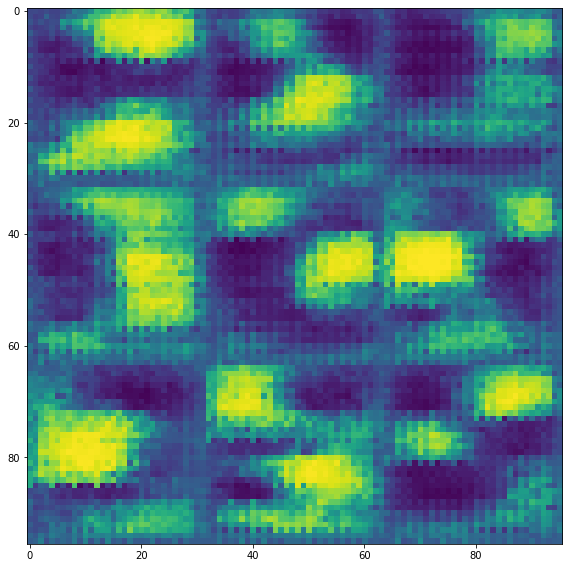

In [191]:
its = 512
epochs = 5

for e in range(epochs):
    tr = trange(its)
    for _ in tr:
        glyph_ae.configure_optim(lr=0.0002, bs=128, noise_size=1 / (epochs - e))
        loss, info = glyph_ae.optim_step()
        tr.set_description(f'Loss: {loss:0.6f}')

    fake_glyphs = glyph_ae(9)
    imshow(fake_glyphs, size=8)
    plt.show()

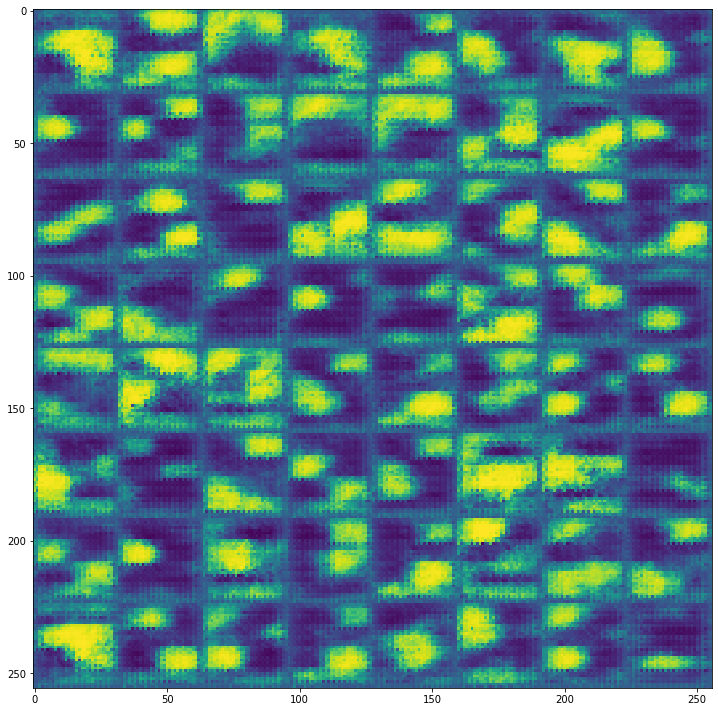

In [192]:
fake_glyphs = glyph_ae(64)
imshow(fake_glyphs, size=10)